# 01 — Exploratory Data Analysis
### CSC 577 | Team Rocket | Food.com Recipe Recommender

This notebook explores the two raw data files:
- `RAW_recipes.csv` — recipe metadata including ingredients, tags, and nutrition
- `RAW_interactions.csv` — user ratings and reviews

**Goals:**
1. Understand the size and shape of the data
2. Identify data quality issues (nulls, duplicates, zero-ratings)
3. Understand rating distribution and user/recipe activity
4. Understand ingredient and tag characteristics
5. Estimate matrix sparsity
6. Decide on filtering thresholds for preprocessing

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import ast
from collections import Counter

# Plot styling
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100

print('Libraries loaded successfully.')

Libraries loaded successfully.


## 1. Load the Data

> **Note:** Place `RAW_recipes.csv` and `RAW_interactions.csv` inside the `data/` folder before running this notebook.

In [2]:
recipes = pd.read_csv('../data/RAW_recipes.csv')
interactions = pd.read_csv('../data/RAW_interactions.csv')

print(f'Recipes shape:      {recipes.shape}')
print(f'Interactions shape: {interactions.shape}')

Recipes shape:      (231637, 12)
Interactions shape: (1132367, 5)


## 2. First Look at the Data

In [3]:
# Recipe columns and first few rows
print('=== RECIPES ===')
print(recipes.dtypes)
recipes.head(3)

=== RECIPES ===
name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [4]:
# Interactions columns and first few rows
print('=== INTERACTIONS ===')
print(interactions.dtypes)
interactions.head(3)

=== INTERACTIONS ===
user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...


## 3. Missing Values & Duplicates

In [5]:
print('=== Missing values in RECIPES ===')
print(recipes.isnull().sum())

print('\n=== Missing values in INTERACTIONS ===')
print(interactions.isnull().sum())

=== Missing values in RECIPES ===
name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

=== Missing values in INTERACTIONS ===
user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64


In [6]:
print(f'Duplicate recipes:      {recipes.duplicated(subset="id").sum()}')
print(f'Duplicate interactions: {interactions.duplicated(subset=["user_id","recipe_id"]).sum()}')

Duplicate recipes:      0
Duplicate interactions: 0


## 4. Rating Distribution

**Important:** Food.com stores a rating of `0` when a user leaves a review *without* giving a star rating. These are NOT valid ratings and must be removed in preprocessing.

In [7]:
print('Rating value counts (including 0):')
print(interactions['rating'].value_counts().sort_index())

zero_ratings = (interactions['rating'] == 0).sum()
print(f'\nZero ratings (to be removed): {zero_ratings} ({zero_ratings/len(interactions)*100:.1f}%)')

Rating value counts (including 0):
rating
0     60847
1     12818
2     14123
3     40855
4    187360
5    816364
Name: count, dtype: int64

Zero ratings (to be removed): 60847 (5.4%)


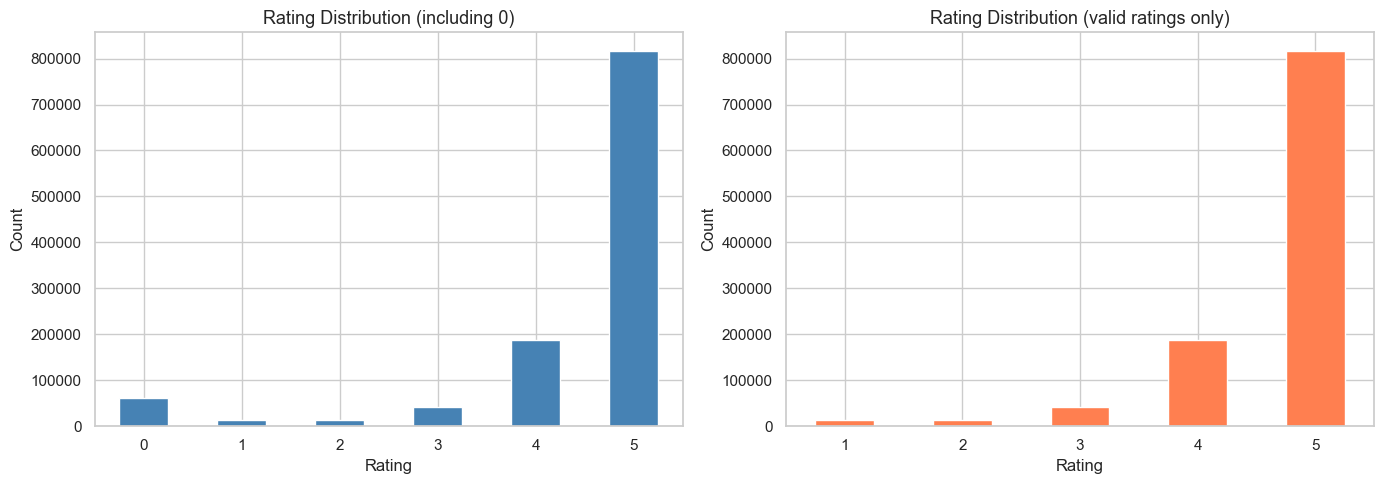


Mean rating (valid only): 4.66
Median rating:            5


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Including zeros
interactions['rating'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', edgecolor='white'
)
axes[0].set_title('Rating Distribution (including 0)', fontsize=13)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Excluding zeros
valid = interactions[interactions['rating'] > 0]
valid['rating'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color='coral', edgecolor='white'
)
axes[1].set_title('Rating Distribution (valid ratings only)', fontsize=13)
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../results/rating_distribution.png', bbox_inches='tight')
plt.show()

print(f'\nMean rating (valid only): {valid["rating"].mean():.2f}')
print(f'Median rating:            {valid["rating"].median():.0f}')

## 5. User Activity Distribution

How many recipes has each user rated? This helps us decide the minimum rating threshold for active users.

In [9]:
user_counts = valid.groupby('user_id')['recipe_id'].count().reset_index()
user_counts.columns = ['user_id', 'num_ratings']

print('Ratings per user — summary statistics:')
print(user_counts['num_ratings'].describe())

print(f'\nUnique users: {user_counts.shape[0]:,}')

# How many users would survive different thresholds?
for threshold in [5, 10, 20, 50]:
    surviving = (user_counts['num_ratings'] >= threshold).sum()
    pct = surviving / len(user_counts) * 100
    print(f'  Users with >= {threshold:>2} ratings: {surviving:>6,}  ({pct:.1f}%)')

Ratings per user — summary statistics:
count    196098.000000
mean          5.464207
std          52.722613
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        7665.000000
Name: num_ratings, dtype: float64

Unique users: 196,098
  Users with >=  5 ratings: 22,018  (11.2%)
  Users with >= 10 ratings: 12,035  (6.1%)
  Users with >= 20 ratings:  6,450  (3.3%)
  Users with >= 50 ratings:  2,669  (1.4%)


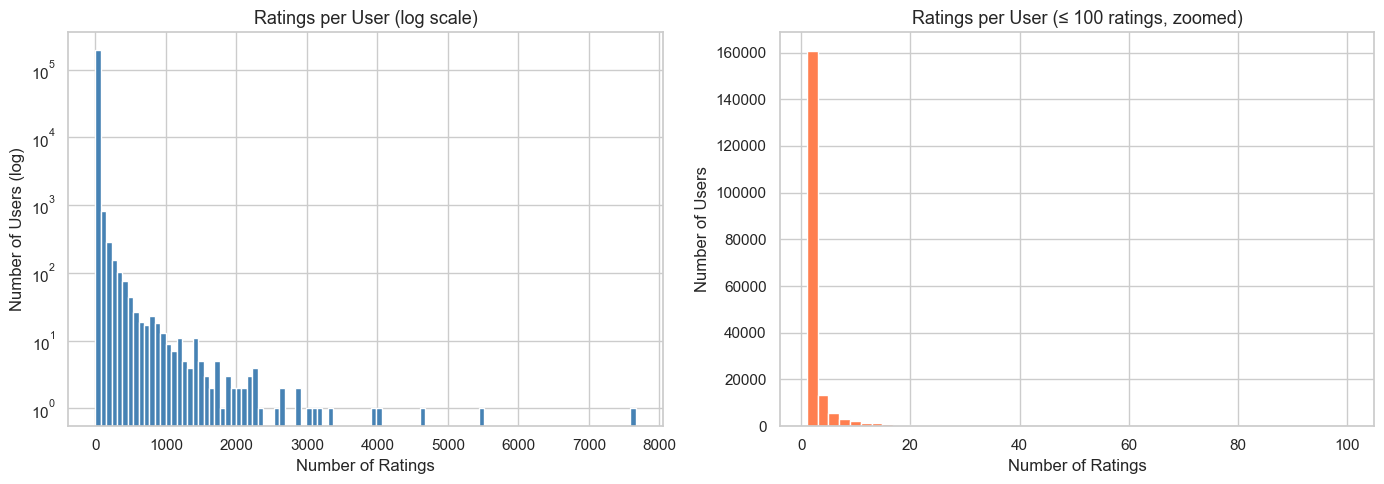

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution (log scale)
axes[0].hist(user_counts['num_ratings'], bins=100, color='steelblue', edgecolor='white')
axes[0].set_yscale('log')
axes[0].set_title('Ratings per User (log scale)', fontsize=13)
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users (log)')

# Zoomed in (<=100 ratings)
axes[1].hist(user_counts[user_counts['num_ratings'] <= 100]['num_ratings'],
             bins=50, color='coral', edgecolor='white')
axes[1].set_title('Ratings per User (≤ 100 ratings, zoomed)', fontsize=13)
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Users')

plt.tight_layout()
plt.savefig('../results/user_activity.png', bbox_inches='tight')
plt.show()

## 6. Recipe Popularity Distribution

How many ratings has each recipe received? This helps set the minimum threshold for popular recipes.

In [11]:
recipe_counts = valid.groupby('recipe_id')['user_id'].count().reset_index()
recipe_counts.columns = ['recipe_id', 'num_ratings']

print('Ratings per recipe — summary statistics:')
print(recipe_counts['num_ratings'].describe())

print(f'\nUnique rated recipes: {recipe_counts.shape[0]:,}')

for threshold in [3, 5, 10, 20]:
    surviving = (recipe_counts['num_ratings'] >= threshold).sum()
    pct = surviving / len(recipe_counts) * 100
    print(f'  Recipes with >= {threshold:>2} ratings: {surviving:>6,}  ({pct:.1f}%)')

Ratings per recipe — summary statistics:
count    226590.000000
mean          4.728894
std          16.582369
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1496.000000
Name: num_ratings, dtype: float64

Unique rated recipes: 226,590
  Recipes with >=  3 ratings: 90,437  (39.9%)
  Recipes with >=  5 ratings: 50,978  (22.5%)
  Recipes with >= 10 ratings: 20,060  (8.9%)
  Recipes with >= 20 ratings:  7,400  (3.3%)


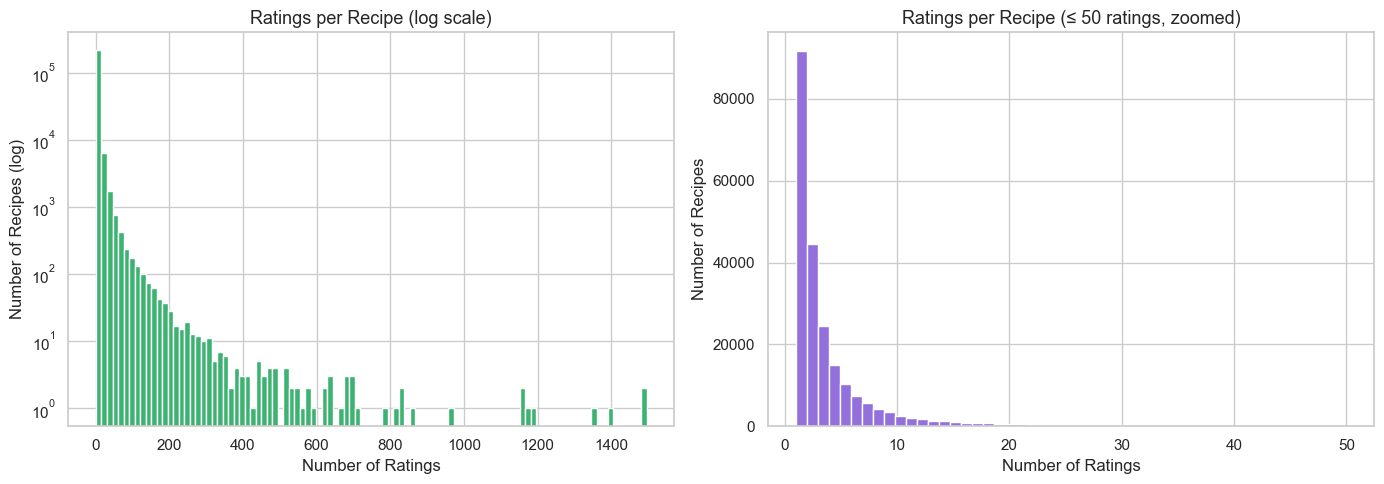

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(recipe_counts['num_ratings'], bins=100, color='mediumseagreen', edgecolor='white')
axes[0].set_yscale('log')
axes[0].set_title('Ratings per Recipe (log scale)', fontsize=13)
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Recipes (log)')

axes[1].hist(recipe_counts[recipe_counts['num_ratings'] <= 50]['num_ratings'],
             bins=50, color='mediumpurple', edgecolor='white')
axes[1].set_title('Ratings per Recipe (≤ 50 ratings, zoomed)', fontsize=13)
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Recipes')

plt.tight_layout()
plt.savefig('../results/recipe_popularity.png', bbox_inches='tight')
plt.show()

## 7. User-Recipe Matrix Sparsity

Sparsity tells us how few ratings exist relative to all possible user-recipe pairs. Very sparse matrices are typical in recommender systems.

In [13]:
n_users = valid['user_id'].nunique()
n_recipes = valid['recipe_id'].nunique()
n_ratings = len(valid)

possible_interactions = n_users * n_recipes
sparsity = 1 - (n_ratings / possible_interactions)

print(f'Unique users:           {n_users:>10,}')
print(f'Unique recipes:         {n_recipes:>10,}')
print(f'Total valid ratings:    {n_ratings:>10,}')
print(f'Possible interactions:  {possible_interactions:>10,}')
print(f'Matrix sparsity:        {sparsity*100:>10.4f}%')

Unique users:              196,098
Unique recipes:            226,590
Total valid ratings:     1,071,520
Possible interactions:  44,433,845,820
Matrix sparsity:           99.9976%


## 8. Ingredient Analysis

The `ingredients` column is stored as a stringified Python list. We parse it and look at the most common ingredients.

In [14]:
# Parse the stringified lists
recipes['ingredients_parsed'] = recipes['ingredients'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Distribution of number of ingredients per recipe
recipes['n_ingredients_actual'] = recipes['ingredients_parsed'].apply(len)

print('Ingredients per recipe — summary statistics:')
print(recipes['n_ingredients_actual'].describe())

Ingredients per recipe — summary statistics:
count    231637.000000
mean          9.051153
std           3.734796
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients_actual, dtype: float64


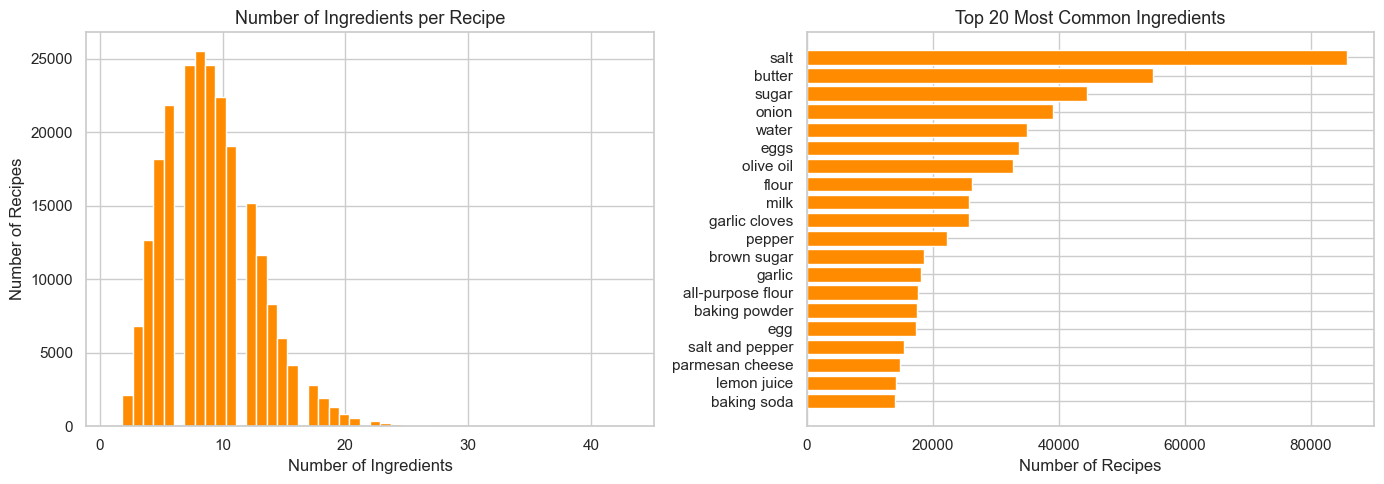


Total unique ingredients: 14,942


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of ingredient counts
axes[0].hist(recipes['n_ingredients_actual'], bins=50, color='darkorange', edgecolor='white')
axes[0].set_title('Number of Ingredients per Recipe', fontsize=13)
axes[0].set_xlabel('Number of Ingredients')
axes[0].set_ylabel('Number of Recipes')

# Top 20 most common ingredients
all_ingredients = [ing for sublist in recipes['ingredients_parsed'] for ing in sublist]
top_ingredients = Counter(all_ingredients).most_common(20)
ing_names, ing_counts = zip(*top_ingredients)

axes[1].barh(ing_names[::-1], ing_counts[::-1], color='darkorange')
axes[1].set_title('Top 20 Most Common Ingredients', fontsize=13)
axes[1].set_xlabel('Number of Recipes')

plt.tight_layout()
plt.savefig('../results/ingredient_analysis.png', bbox_inches='tight')
plt.show()

print(f'\nTotal unique ingredients: {len(set(all_ingredients)):,}')

## 9. Tag Analysis

Tags include cuisine types, dietary labels, and cooking methods — useful as content features.

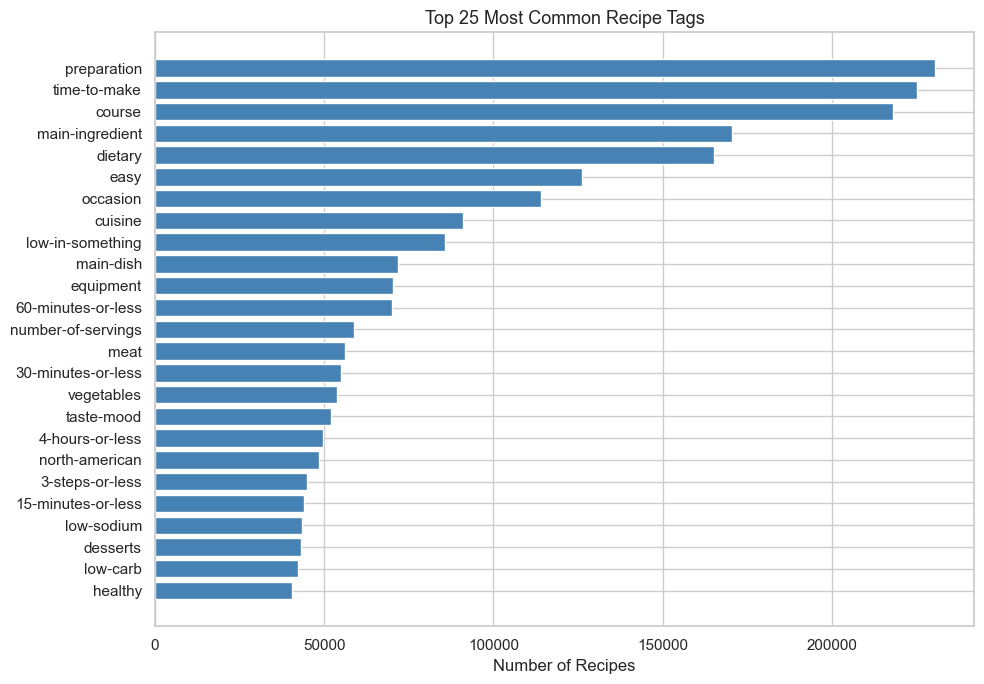

Total unique tags: 552


In [16]:
recipes['tags_parsed'] = recipes['tags'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

all_tags = [tag for sublist in recipes['tags_parsed'] for tag in sublist]
top_tags = Counter(all_tags).most_common(25)
tag_names, tag_counts = zip(*top_tags)

plt.figure(figsize=(10, 7))
plt.barh(tag_names[::-1], tag_counts[::-1], color='steelblue')
plt.title('Top 25 Most Common Recipe Tags', fontsize=13)
plt.xlabel('Number of Recipes')
plt.tight_layout()
plt.savefig('../results/tag_analysis.png', bbox_inches='tight')
plt.show()

print(f'Total unique tags: {len(set(all_tags)):,}')

## 10. Cooking Time Distribution

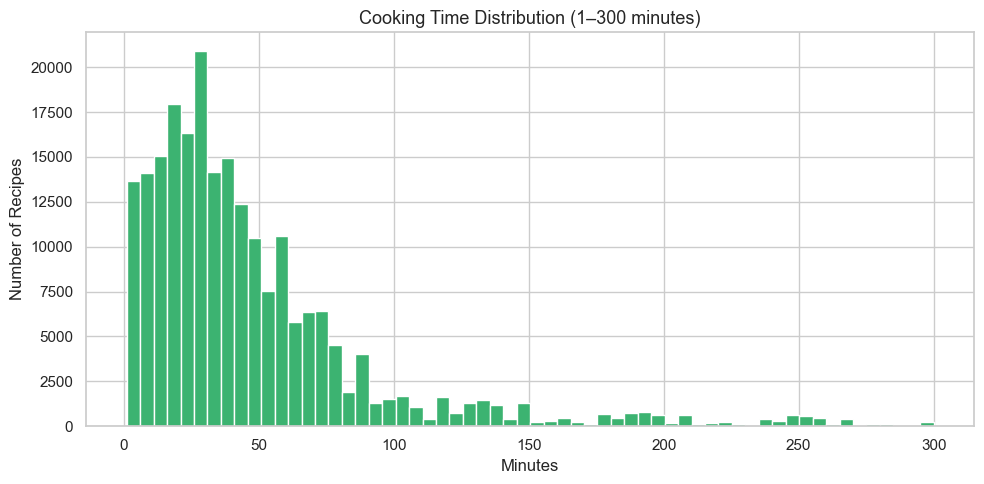

Recipes with > 300 min cook time: 9,970
Recipes with minutes = 0:         1,094

Median cook time: 40 min
Mean cook time:   9399 min


In [17]:
# There are extreme outliers in minutes — cap for visualization
minutes_clean = recipes[recipes['minutes'].between(1, 300)]['minutes']

plt.figure(figsize=(10, 5))
plt.hist(minutes_clean, bins=60, color='mediumseagreen', edgecolor='white')
plt.title('Cooking Time Distribution (1–300 minutes)', fontsize=13)
plt.xlabel('Minutes')
plt.ylabel('Number of Recipes')
plt.tight_layout()
plt.savefig('../results/cooking_time.png', bbox_inches='tight')
plt.show()

print(f'Recipes with > 300 min cook time: {(recipes["minutes"] > 300).sum():,}')
print(f'Recipes with minutes = 0:         {(recipes["minutes"] == 0).sum():,}')
print(f'\nMedian cook time: {recipes["minutes"].median():.0f} min')
print(f'Mean cook time:   {recipes["minutes"].mean():.0f} min')

## 11. Average Rating per Recipe

What does the distribution of *average* recipe ratings look like?

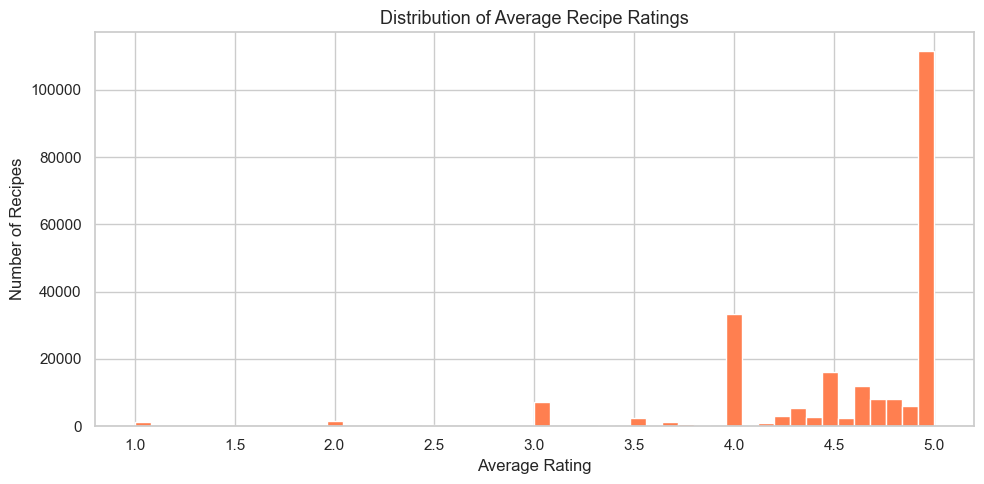

Mean of avg ratings:   4.58
Median of avg ratings: 4.89


In [18]:
avg_ratings = valid.groupby('recipe_id')['rating'].mean()

plt.figure(figsize=(10, 5))
plt.hist(avg_ratings, bins=50, color='coral', edgecolor='white')
plt.title('Distribution of Average Recipe Ratings', fontsize=13)
plt.xlabel('Average Rating')
plt.ylabel('Number of Recipes')
plt.tight_layout()
plt.savefig('../results/avg_recipe_ratings.png', bbox_inches='tight')
plt.show()

print(f'Mean of avg ratings:   {avg_ratings.mean():.2f}')
print(f'Median of avg ratings: {avg_ratings.median():.2f}')

## 12. Summary & Preprocessing Decisions

Based on the EDA above, here are the decisions we carry into `02_preprocessing.ipynb`:

In [19]:
summary = {
    'Total recipes':                  len(recipes),
    'Total interactions':             len(interactions),
    'Interactions with rating=0':     (interactions['rating'] == 0).sum(),
    'Valid interactions (rating>0)':  len(valid),
    'Unique users (valid)':           n_users,
    'Unique recipes (valid)':         n_recipes,
    'Matrix sparsity':                f'{sparsity*100:.4f}%',
    'Unique ingredients':             len(set(all_ingredients)),
}

for k, v in summary.items():
    print(f'{k:<40} {v}')

print('\n--- Preprocessing Decisions ---')
print('1. Remove ratings where rating == 0')
print('2. Keep users with >= 10 ratings')
print('3. Keep recipes with >= 5 ratings')
print('4. Parse ingredients and tags from stringified lists')
print('5. Save cleaned data to data/processed/')

Total recipes                            231637
Total interactions                       1132367
Interactions with rating=0               60847
Valid interactions (rating>0)            1071520
Unique users (valid)                     196098
Unique recipes (valid)                   226590
Matrix sparsity                          99.9976%
Unique ingredients                       14942

--- Preprocessing Decisions ---
1. Remove ratings where rating == 0
2. Keep users with >= 10 ratings
3. Keep recipes with >= 5 ratings
4. Parse ingredients and tags from stringified lists
5. Save cleaned data to data/processed/
